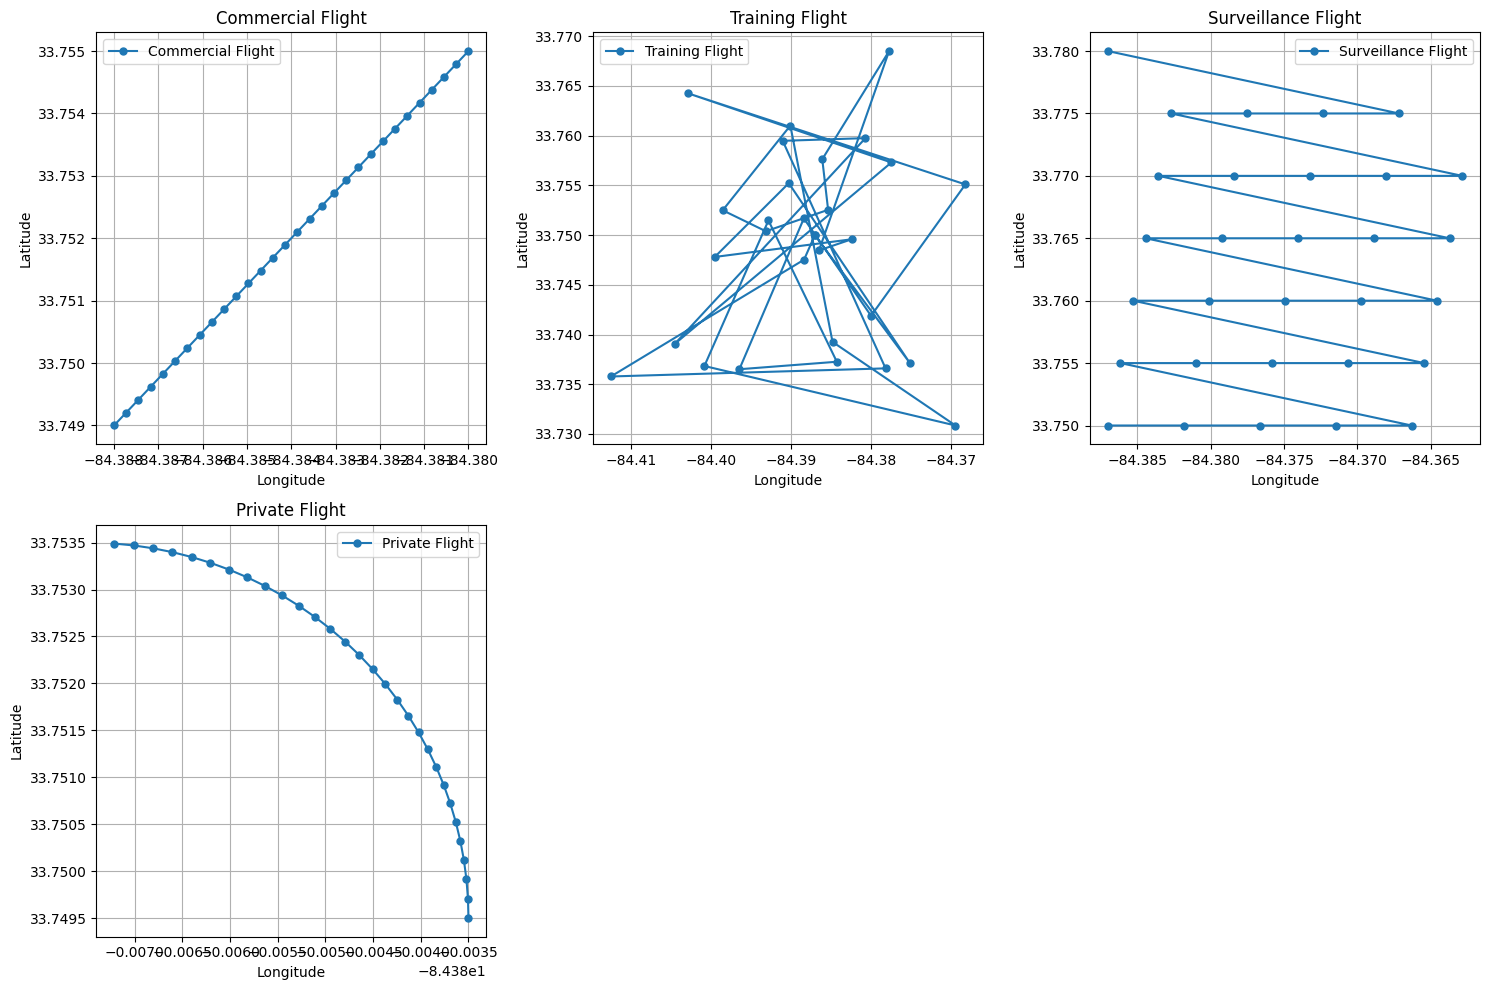

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
from src.prototypes import classify_flight_path
from src.pca_k_means import pca_kmeans_clustering

In [ ]:
#this method can be used to plot a flight path with predicted labels

def plot_flight_paths(data):
    

    for flight_id, flight_data in data.groupby("flight_id"):
        # Get min/max bounds for the dataset
        min_long, max_long = flight_data["long"].min(), flight_data["long"].max()
        min_lat, max_lat = flight_data["lat"].min(), flight_data["lat"].max()
        # Create a new figure for each flight
        plt.figure(figsize=(10, 5))

        # Plot the individual flight path with the predicted label
        plt.plot(flight_data["long"], flight_data["lat"], alpha=0.7, linewidth=1,
                 label=f"Predicted: {flight_data['label'].iloc[0]}")

        # Set labels and title for the plot
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.title(f"Flight Path for Flight ID: {flight_id} with Predicted Label")
        plt.grid(True)
        
        # Apply calculated bounds with padding
        plt.xlim(min_long - 0.01, max_long + 0.01)
        plt.ylim(min_lat - 0.01, max_lat + 0.01)

        # Display legend and plot
        plt.legend(loc="upper right", fontsize="small", ncol=2)
        plt.show()

# def plot_flight_paths(data):
#     # Determine the number of unique flight IDs
#     num_flights = len(data['flight_id'].unique())
    
#     # Calculate number of rows and columns for the grid
#     ncols = 3  # You can adjust this to have more or fewer columns
#     nrows = math.ceil(num_flights / ncols)  # Calculate required rows for the grid

#     # Create a single figure for all the plots
#     fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
#     axes = axes.flatten()  # Flatten the axes array for easy iteration
    
    
#     for i, (flight_id, flight_data) in enumerate(data.groupby("flight_id")):
#         # Get min/max bounds for the dataset
#         min_long, max_long = flight_data["long"].min(), flight_data["long"].max()
#         min_lat, max_lat = flight_data["lat"].min(), flight_data["lat"].max()

#         # Get the current axis for plotting
#         ax = axes[i]

#         # Plot the individual flight path with the predicted label
#         ax.plot(flight_data["long"], flight_data["lat"], alpha=0.7, linewidth=1,
#                 label=f"Predicted: {flight_data['label'].iloc[0]}")

#         # Set labels and title for the plot
#         ax.set_xlabel("Longitude")
#         ax.set_ylabel("Latitude")
#         ax.set_title(f"Flight Path for Flight ID: {flight_id}")

#         # Apply calculated bounds with padding
#         ax.set_xlim(min_long - 0.01, max_long + 0.01)
#         ax.set_ylim(min_lat - 0.01, max_lat + 0.01)

#         # Display legend
#         ax.legend(loc="upper right", fontsize="small", ncol=2)
#         ax.grid(True)

#      # Hide any empty subplots
#     for j in range(num_flights, len(axes)):
#         axes[j].axis('off')

#     # Adjust layout to prevent overlap
#     plt.tight_layout()
#     plt.show()

In [15]:

def estimate_barometric_altitude(df, geoalt_col='geoaltitude'):
    """
    Convert geometric altitude to barometric altitude for an entire DataFrame.
    Uses the ISA model to estimate pressure and derive barometric altitude.
    
    :param df: Pandas DataFrame with a column for geoaltitude.
    :param geoalt_col: Name of the column containing geoaltitude values.
    :return: DataFrame with a new 'baro_altitude' column.
    """
    # Constants from the ISA model
    P0 = 1013.25  # hPa (sea level pressure)
    L = 0.0065    # K/m (lapse rate)
    T0 = 288.15   # K (sea level temperature)
    g = 9.80665   # m/s² (gravity)
    M = 0.0289644 # kg/mol (molar mass of air)
    R = 8.31432   # J/(mol·K) (universal gas constant)

    # Compute estimated pressure at geoaltitude
    df['pressure'] = P0 * (1 - (L * df[geoalt_col]) / T0) ** ((g * M) / (R * L))

    # Compute barometric altitude
    df['baro_altitude'] = df[geoalt_col] - (T0 / L) * (1 - (df['pressure'] / P0) ** ((R * L) / g))
    
    return df




In [16]:
def load_parquet_data(path):
    
    #df = pd.read_parquet('C:\\Users\\mitch\\Downloads\\enid_data\\enid_data\\processed_state_vectors_chunk_1.parquet')
    columns_needed = ['icao24', 'lat', 'lon', 'velocity','geoaltitude']

    df = pd.read_parquet(path, columns=columns_needed)
    
    
    random_flight_ids = df['icao24'].dropna().unique()
    sampled_flight_ids = pd.Series(random_flight_ids).sample(n=25, random_state=42)

    # Filter the dataframe to include only those flight_ids
    sampled_data = df[df['icao24'].isin(sampled_flight_ids)]

    sampled_data = estimate_barometric_altitude(sampled_data)

    #print("Sampled data", sampled_data.head())
    #update column names
    sampled_data = sampled_data.rename(columns={'baro_altitude': 'altitude', 'icao24' : 'flight_id', 'lon':'long', 'velocity': 'speed'})

    return sampled_data

load_parquet_data('C:\\Users\\mitch\\Downloads\\enid_data\\enid_data\\processed_state_vectors_chunk_1.parquet')   




C:\Users\mitch\AppData\Local\Temp\ipykernel_21164\1543617519.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pressure'] = P0 * (1 - (L * df[geoalt_col]) / T0) ** ((g * M) / (R * L))
C:\Users\mitch\AppData\Local\Temp\ipykernel_21164\1543617519.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['baro_altitude'] = df[geoalt_col] - (T0 / L) * (1 - (df['pressure'] / P0) ** ((R * L) / g))


,flight_id,lat,long,speed,geoaltitude,pressure,altitude
633013,a6ef4a,32.680252,-83.820245,79.464531,2209.80,774.461509,2144.192712
633014,a6ef4a,32.680252,-83.820245,79.464531,2202.18,775.198172,2136.804636
633015,a6ef4a,32.680435,-83.822607,79.464531,2225.04,772.989884,2158.968743
633016,a6ef4a,32.680435,-83.822607,79.464531,2225.04,772.989884,2158.968743
633017,a6ef4a,32.680527,-83.824255,79.464531,2225.04,772.989884,2158.968743
...,...,...,...,...,...,...,...
20571287,a3b86c,34.993149,-81.525785,234.474185,10424.16,247.641116,10081.288389
20571288,a3b86c,34.994522,-81.523880,234.474185,10424.16,247.641116,10081.288389
20571289,a3b86c,34.996033,-81.521750,234.474185,10424.16,247.641116,10081.288389
20571290,a3b86c,34.997452,-81.519788,234.474185,10424.16,247.641116,10081.288389


In [17]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
def generate_cm(data):
    # Example data - flight_paths or any other dataset
    # X: your features (use a subset of features, not including 'flight_id' or 'label')
    # In this case, replace this with your actual data.
    X = data[['lat', 'long', 'altitude', 'speed']].values
    # Step 1: Apply KMeans clustering to your data
    kmeans = KMeans(n_clusters=3, random_state=42)
    cluster_labels = kmeans.fit_predict(X).astype(str)

    # Step 2: Assign true labels (or use actual labels if available)
    # For the sake of demonstration, let's assume true labels are provided or generated
    true_labels = data['label'].astype(str).values
    # Convert true labels and predicted cluster labels to strings


    # Step 3: Generate confusion matrix comparing true labels with predicted cluster labels
    cm = confusion_matrix(true_labels, cluster_labels)

    # Step 4: Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(3, 3))
    cax = ax.matshow(cm, cmap='Blues')
    fig.colorbar(cax)
    plt.title("Confusion Matrix - Clustering vs. True Labels")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(np.arange(3), ['Cluster 0', 'Cluster 1', 'Cluster 2'])
    plt.yticks(np.arange(3), ['True 0', 'True 1', 'True 2'])
    plt.show()

    # Print confusion matrix
    print("Confusion Matrix:")
    print(cm)


In [18]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
def generate_ari_score(data):
    # Simulated flight path feature data (replace with your actual data)
    # Each row represents a flight, and columns represent features like speed, altitude, etc.
   # flight_paths = np.random.rand(100, 3)  # 100 flight paths, 3 features (for example)
    labels = data['label'].values
    flight_paths = data.drop(columns=['flight_id', 'label'])
    # Step 1: Apply KMeans clustering to your data
    # Assuming we want to classify into 3 clusters (e.g., commercial, training, other)
    print(flight_paths.shape)
    print(flight_paths.dtypes)
    kmeans = KMeans(n_clusters=4, random_state=42)
    cluster_labels = kmeans.fit_predict(flight_paths)

    # Step 2: Simulate prototype-based predicted labels (replace this with your actual model's output)
    # These are your predicted labels based on prototypes (you can replace this with your model's output)
    prototype_predicted_labels = labels

    # Step 3: Evaluate the performance using Adjusted Rand Index (ARI)
    # ARI is a measure of similarity between two clusterings, adjusted for chance
    ari_score = adjusted_rand_score(cluster_labels, prototype_predicted_labels)

    # Print the ARI score (higher ARI means the cluster assignments are more similar to predicted labels)
    print(f"Adjusted Rand Index: {ari_score}")


    # Step 4: Visualizing the clustering (optional)
    # If your data is 2D or you want to reduce it to 2D for visualization, use PCA or t-SNE
    from sklearn.decomposition import PCA

    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(flight_paths)

    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis', label='Cluster Labels')
    plt.title("KMeans Clustering of Flight Paths")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.colorbar(label='Cluster')
    plt.show()

    # Visualize prototype-based predictions (optional)
    static_colors = ['red', 'blue', 'green', 'orange', 'purple']  # A list of static colors
    color_cycle = np.tile(static_colors, len(reduced_data) // len(static_colors) + 1)  # Repeat colors to match the number of points

    # Visualize with static colors
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=color_cycle[:len(reduced_data)], marker='x')

    # Add title and labels
    plt.title("Flight Paths with Static Colors")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")

    # Display the plot
    plt.show()




C:\Users\mitch\AppData\Local\Temp\ipykernel_21164\1543617519.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pressure'] = P0 * (1 - (L * df[geoalt_col]) / T0) ** ((g * M) / (R * L))
C:\Users\mitch\AppData\Local\Temp\ipykernel_21164\1543617519.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['baro_altitude'] = df[geoalt_col] - (T0 / L) * (1 - (df['pressure'] / P0) ** ((R * L) / g))


{'Commercial Flight': np.float64(463429.5639064671), 'Training Flight': np.float64(136616.04631226242), 'Surveillance Flight': np.float64(3576.914400435356), 'Private Flight': np.float64(194610.1822243085)}
{'Commercial Flight': np.float64(474026.7043582224), 'Training Flight': np.float64(126018.1074425699), 'Surveillance Flight': np.float64(14027.346457070105), 'Private Flight': np.float64(184003.88965791956)}
{'Commercial Flight': np.float64(567839.5747766095), 'Training Flight': np.float64(95230.92448126178), 'Surveillance Flight': np.float64(133345.94887707607), 'Private Flight': np.float64(129501.70577964786)}
{'Commercial Flight': np.float64(488245.52116776275), 'Training Flight': np.float64(113838.79358702485), 'Surveillance Flight': np.float64(33906.12823954244), 'Private Flight': np.float64(171207.78271492242)}
{'Commercial Flight': np.float64(549873.954802011), 'Training Flight': np.float64(50224.74094337071), 'Surveillance Flight': np.float64(89867.14827550066), 'Private Fli

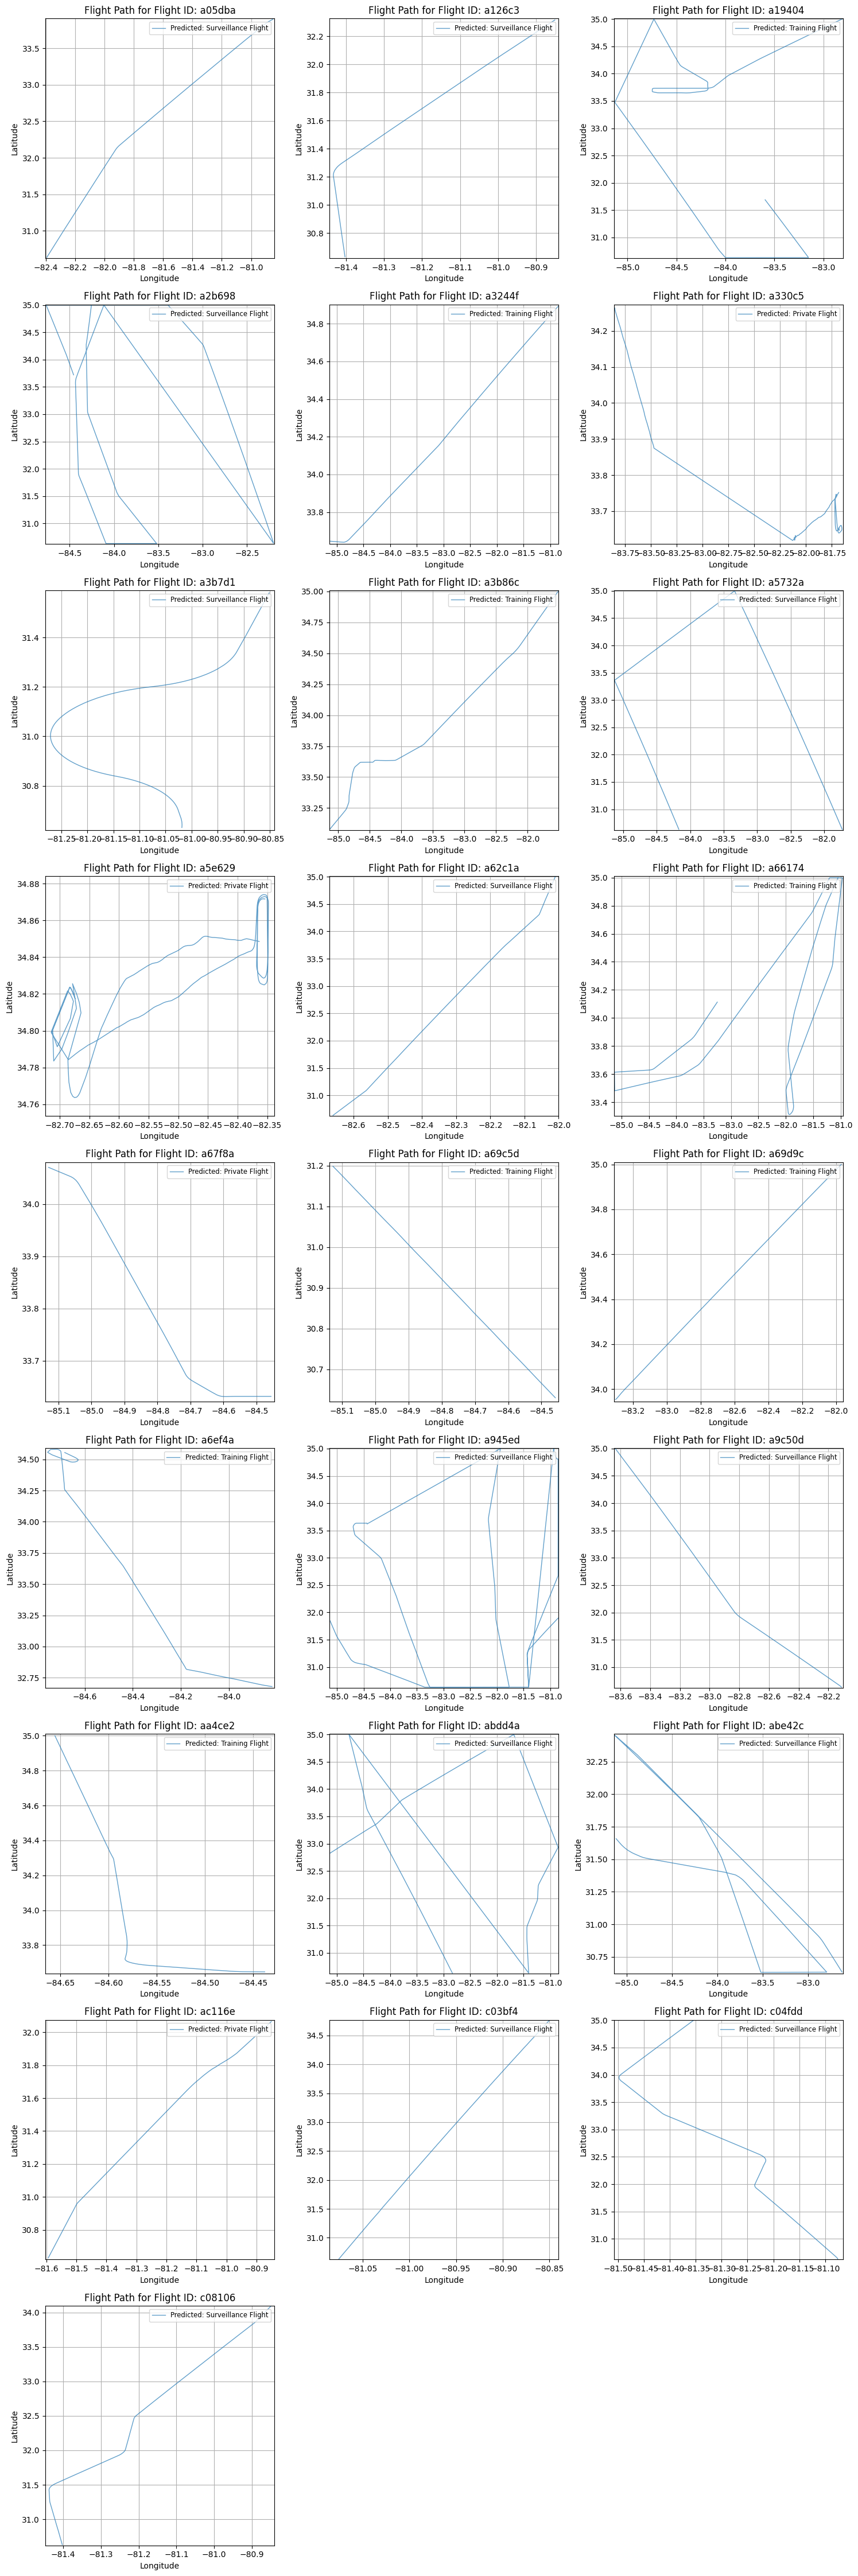

(70188, 6)
lat            float64
long           float64
speed          float64
geoaltitude    float64
pressure       float64
altitude       float64
dtype: object
Adjusted Rand Index: 0.4887134107779251


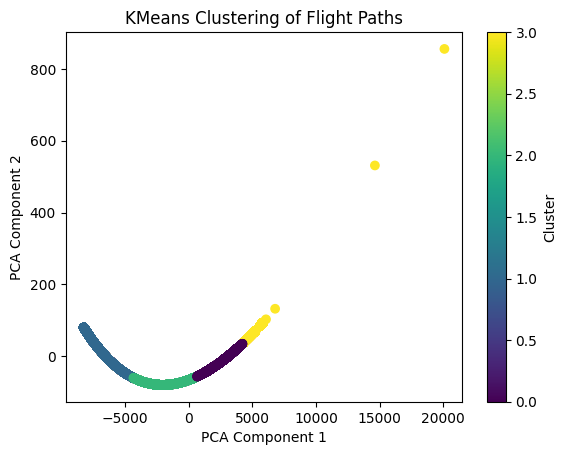

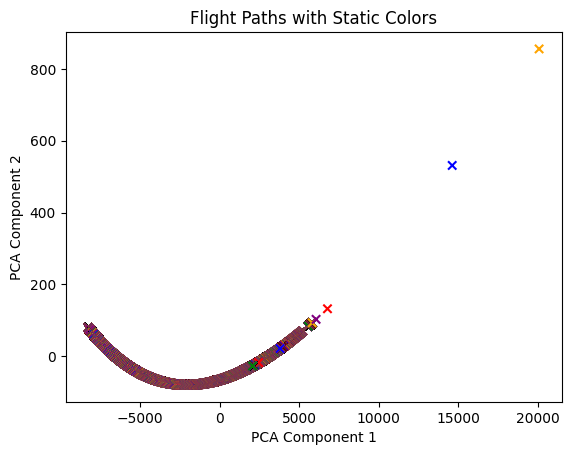

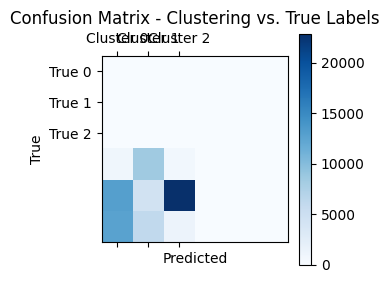

Confusion Matrix:
[[    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [    0     0     0     0     0     0]
 [  842  8469   649     0     0     0]
 [12901  4441 22895     0     0     0]
 [12617  6076  1298     0     0     0]]


c:\Users\mitch\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8359 - loss: 2.4012e-05 - val_accuracy: 0.8931 - val_loss: 0.2663
Epoch 2/20
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9088 - loss: 1.1870e-05 - val_accuracy: 0.9236 - val_loss: 0.1931
Epoch 3/20
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9230 - loss: 9.2938e-06 - val_accuracy: 0.9381 - val_loss: 0.1585
Epoch 4/20
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9420 - loss: 7.0102e-06 - val_accuracy: 0.9492 - val_loss: 0.1271
Epoch 5/20
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9568 - loss: 5.4546e-06 - val_accuracy: 0.9690 - val_loss: 0.0837
Epoch 6/20
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9690 - loss: 4.1842e-06 - val_accuracy: 0.9700 - val_loss: 0.0750
Epoch 7/20
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9724 - loss: 3.9271e-06 - val_accuracy: 0.9616 - val_loss: 0.0871
Epoch 8/20
1749/1749 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accura

C:\Users\mitch\AppData\Local\Temp\ipykernel_21164\1543617519.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pressure'] = P0 * (1 - (L * df[geoalt_col]) / T0) ** ((g * M) / (R * L))
C:\Users\mitch\AppData\Local\Temp\ipykernel_21164\1543617519.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['baro_altitude'] = df[geoalt_col] - (T0 / L) * (1 - (df['pressure'] / P0) ** ((R * L) / g))


['3949e9', 'a08021', 'a0cf92', 'a262f5', 'a32ddd', 'a37d3d', 'a37dc2', 'a3822d', 'a48ba6', 'a4992e', 'a4f261', 'a676c4', 'a7c40c', 'a8fc72', 'a90e61', 'a996f3', 'aa1a45', 'aa31c2', 'ac41f3', 'ac4bfe', 'ac5488', 'ac7325', 'acb679', 'ad4c2a', 'ad4eba']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step


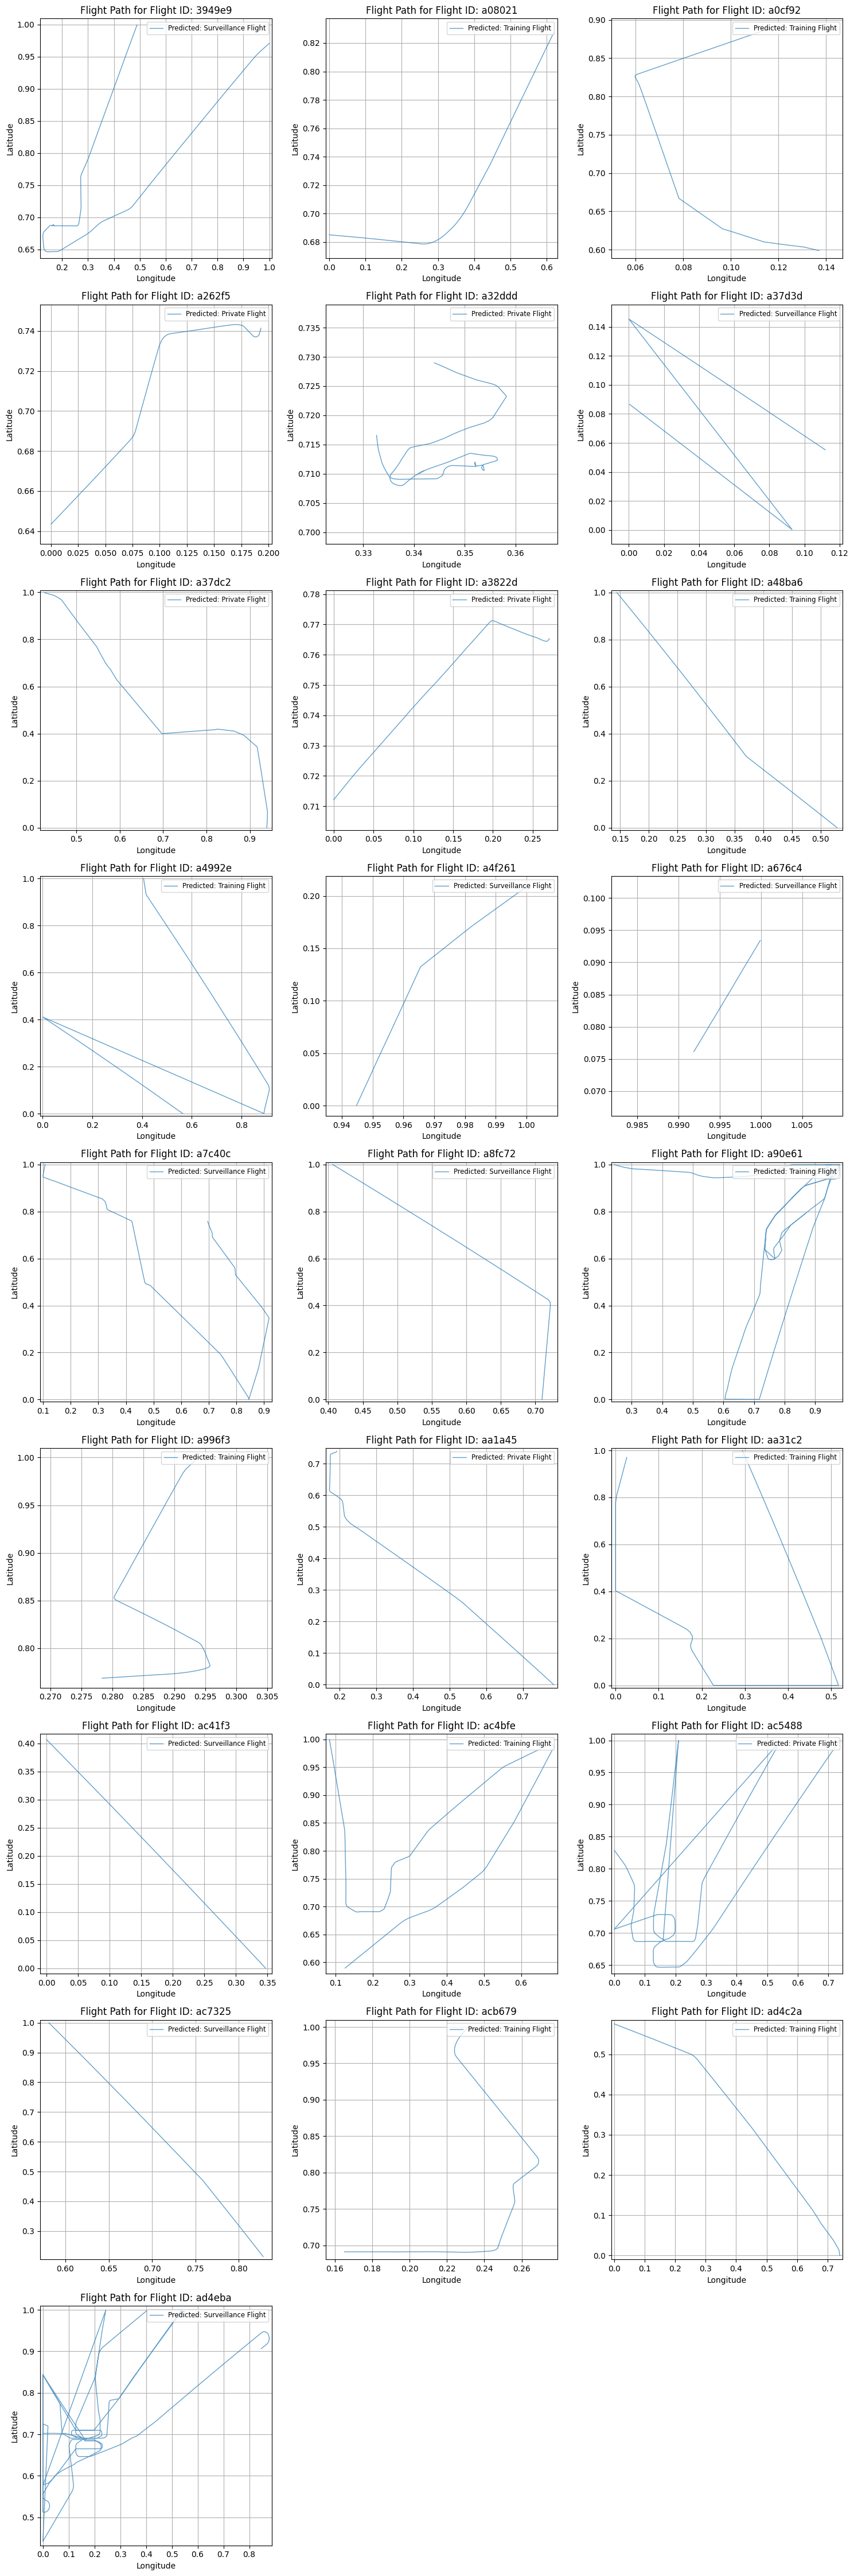

In [19]:
#Unspervised Learning #1 using DTW to label unlabled flight paths by matching paths to 

# Load Flight Data
data = load_parquet_data('C:\\Users\\mitch\\Downloads\\enid_data\\enid_data\\processed_state_vectors_chunk_1.parquet')

# Label the flight paths using the 4D distance method
def label_flight_paths(data):
    labels = [(flight_id, classify_flight_path(flight_data[['lat', 'long', 'altitude', 'speed']].values.tolist()))
              for flight_id, flight_data in data.groupby('flight_id')]
    return pd.DataFrame(labels, columns=['flight_id', 'label'])

data = data.merge(label_flight_paths(data), on='flight_id', how='left')
plot_flight_paths(data)
# Normalize Data
scaler = MinMaxScaler()
data[['lat', 'long', 'altitude', 'speed']] = scaler.fit_transform(data[['lat', 'long', 'altitude', 'speed']])

generate_ari_score(data)
generate_cm(data)
# Generate Sequences
label_encoder = LabelEncoder()
data['encoded_label'] = label_encoder.fit_transform(data['label'])


flight_lengths = data.groupby('flight_id').size()
optimal_timesteps = int(np.percentile(flight_lengths, 25))  # Use the median length

timesteps = 10
X, y = [], []
for flight_id, flight_data in data.groupby('flight_id'):
    flight_scaled = flight_data[['lat', 'long', 'altitude', 'speed']].values
    flight_labels = flight_data['encoded_label'].values
    for i in range(len(flight_scaled) - timesteps):
        X.append(flight_scaled[i:i+timesteps])
        y.append(flight_labels[i+timesteps])

X, y = np.array(X), np.array(y, dtype=np.int32)

# Train CNN Model with class weighting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class_weights = {i: 1 / (np.sum(y_train == i) + 1e-6) for i in np.unique(y_train)}

model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(timesteps, 4)),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32, class_weight=class_weights)

# Evaluate Model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

# Predict on New Data
new_flight_data = load_parquet_data('C:\\Users\\mitch\\Downloads\\enid_data\\enid_data\\processed_state_vectors_chunk_2.parquet')#pd.read_csv('test_data/categorized_test_data_mocked.csv')
new_flight_data[['lat', 'long', 'altitude', 'speed']] = scaler.transform(new_flight_data[['lat', 'long', 'altitude', 'speed']])

# Ensure minimum sequence length is valid
valid_flights = [flight_id for flight_id, flight_data in new_flight_data.groupby('flight_id') if len(flight_data) >= timesteps]
print (valid_flights)
# Generate sequences only from valid flights
new_X = [flight_data[['lat', 'long', 'altitude', 'speed']].values[:timesteps]  # Take first 'timesteps' rows
         for flight_id, flight_data in new_flight_data.groupby('flight_id') if flight_id in valid_flights]

if new_X:  # Ensure we have valid sequences before predicting
    new_X = np.array(new_X)
    predictions = model.predict(new_X)
    predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))
    
    # Create an empty column
    new_flight_data['label'] = None

    # Map predicted labels to flight_id and assign row-wise
    flight_to_label = dict(zip(valid_flights, predicted_labels))  # Create a lookup dictionary

    # Apply the mapping
    new_flight_data.loc[new_flight_data['flight_id'].isin(valid_flights), 'label'] = \
        new_flight_data['flight_id'].map(flight_to_label)

    new_flight_data.head()

else:
    print("No valid sequences found for prediction.")

plot_flight_paths(new_flight_data)

C:\Users\mitch\AppData\Local\Temp\ipykernel_21164\1543617519.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pressure'] = P0 * (1 - (L * df[geoalt_col]) / T0) ** ((g * M) / (R * L))
C:\Users\mitch\AppData\Local\Temp\ipykernel_21164\1543617519.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['baro_altitude'] = df[geoalt_col] - (T0 / L) * (1 - (df['pressure'] / P0) ** ((R * L) / g))


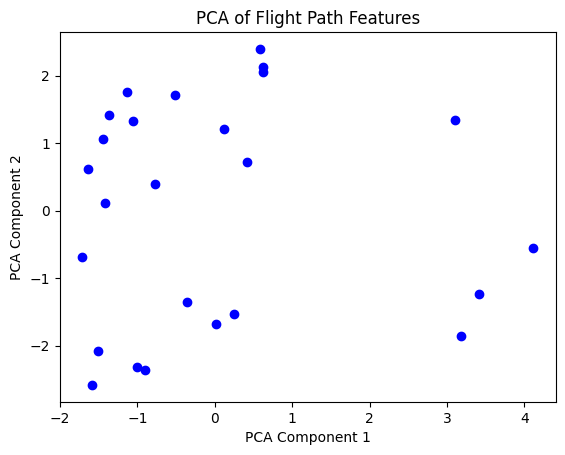

Cluster Centers:
     lat_var  long_var       alt_var    speed_var   avg_speed  avg_altitude  \
0  1.273931  1.098387  1.983214e+06  1057.591082  223.429154  11009.869449   
1  0.125107  0.294214  1.884644e+06   406.332258  203.640033   7839.740925   
2  0.690085  0.969135  1.396048e+07  3410.437691  183.533003   5766.575270   
3  1.349074  0.078589  2.982293e+05    72.738992  229.903495  11517.643810   
4  0.154658  0.193606  1.213073e+06   382.989832   75.833002   1775.392447   

   altitude_range  alternating_changes  
0     4085.077473           543.200000  
1     2879.942491            57.833333  
2    14683.615418           283.000000  
3     3435.860164           132.166667  
4     3227.608966           193.800000  
Cluster 0: {'lat_var': 1.2739307430865079, 'long_var': 1.09838711725022, 'alt_var': 1983213.7173401224, 'speed_var': 1057.5910816392907, 'avg_speed': 223.42915352286886, 'avg_altitude': 11009.869448618745, 'altitude_range': 4085.077472974177, 'alternating_changes': 5

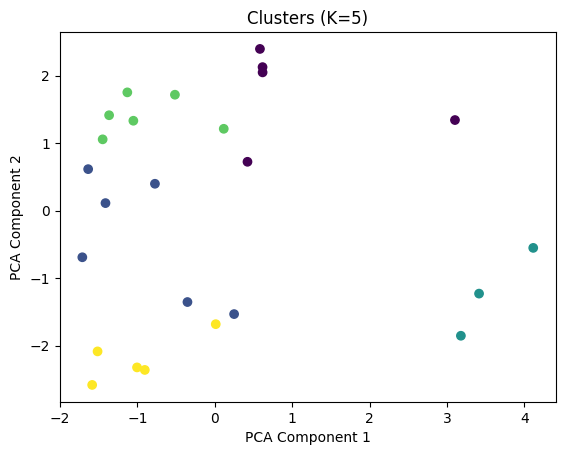

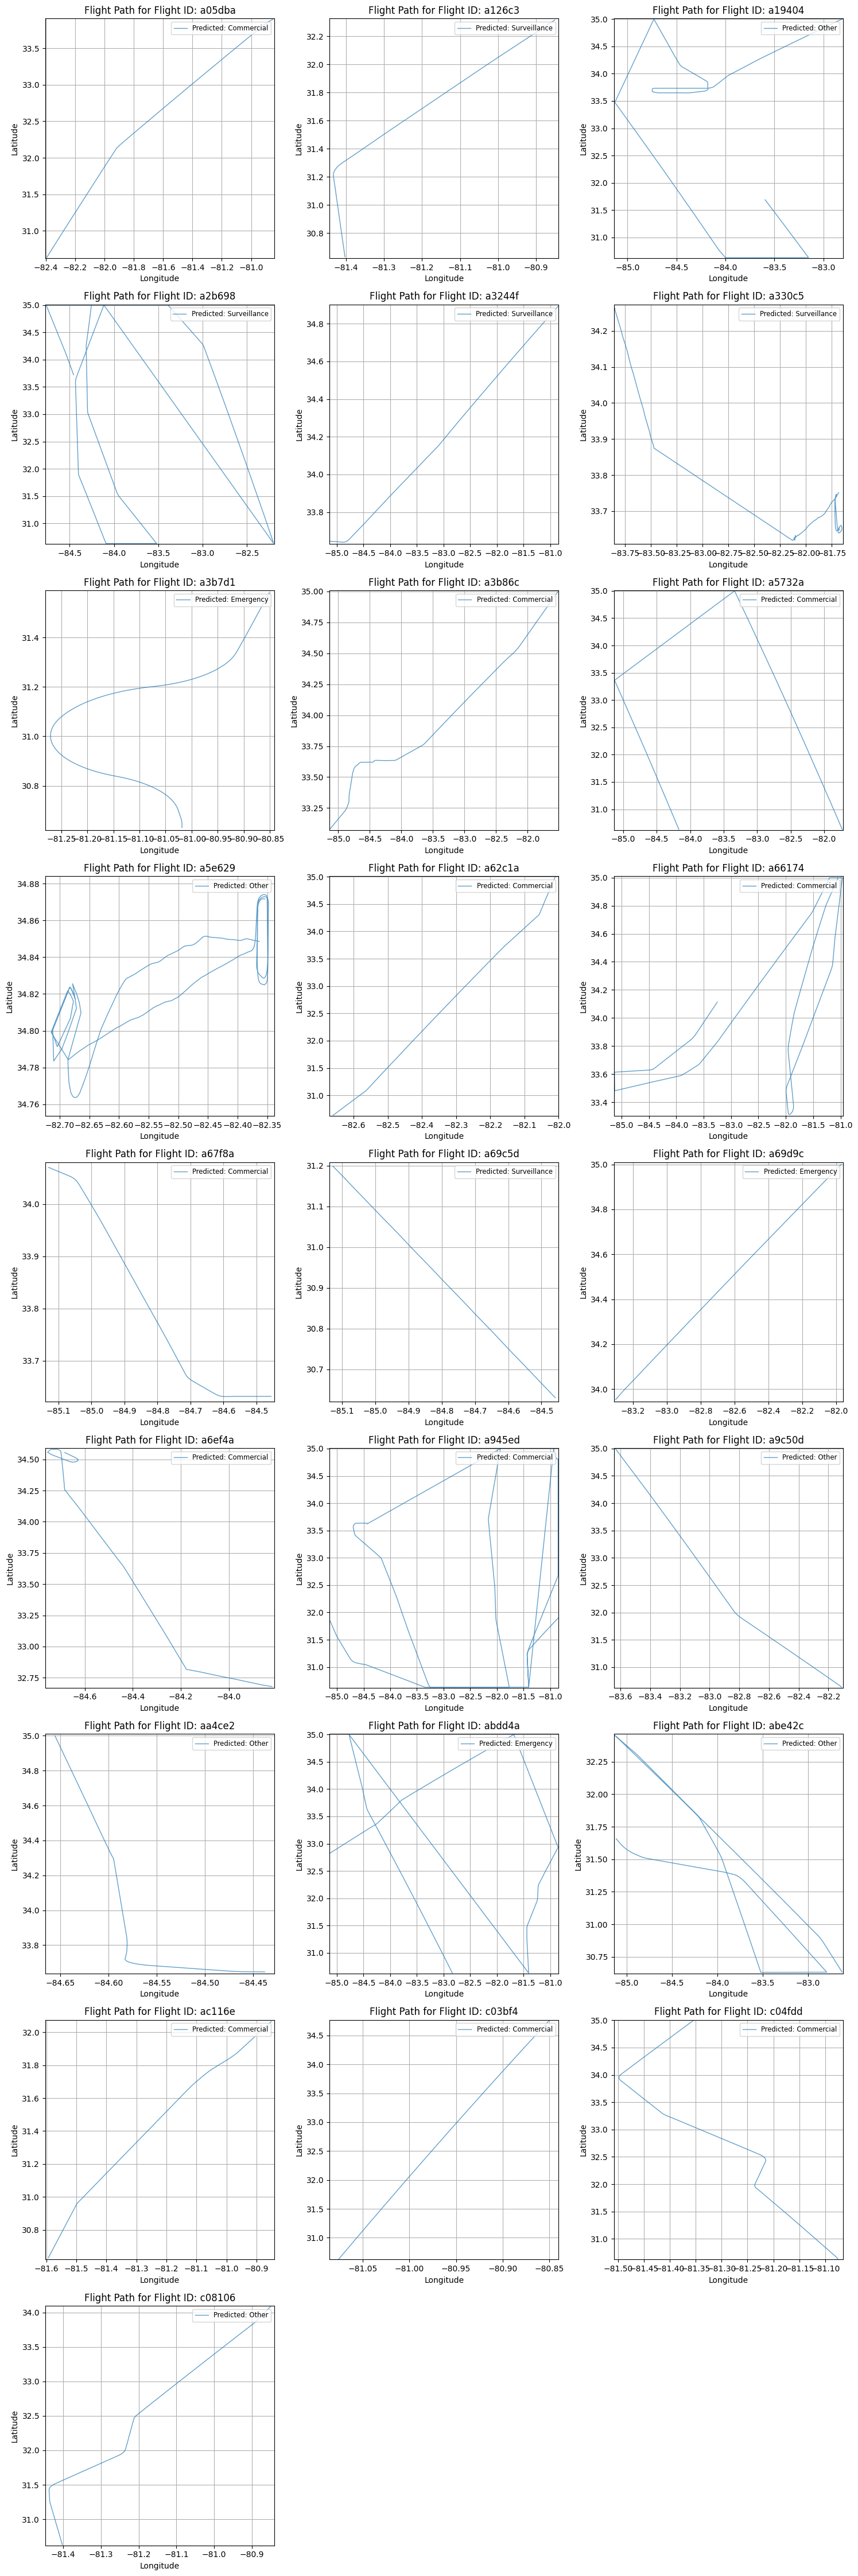

(70188, 6)
lat            float64
long           float64
speed          float64
geoaltitude    float64
pressure       float64
altitude       float64
dtype: object
Adjusted Rand Index: -0.02138355944411667


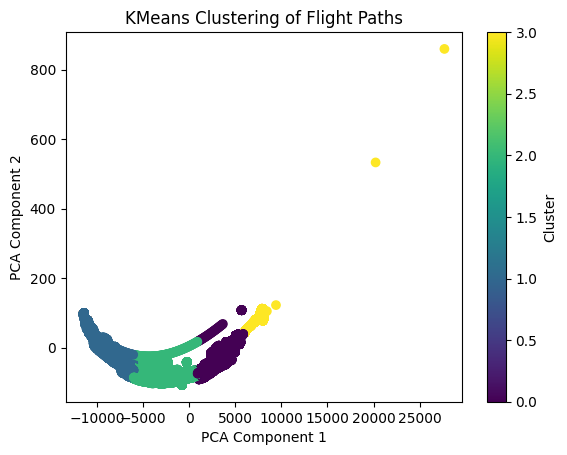

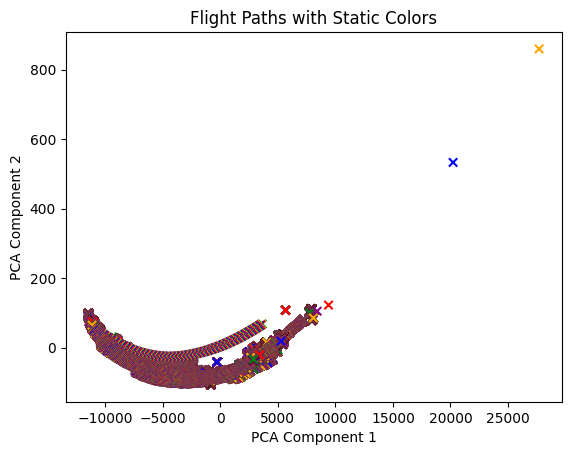

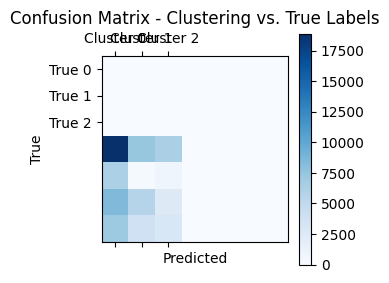

Confusion Matrix:
[[    0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0]
 [18927  7413  6295     0     0     0     0]
 [ 6222   271   758     0     0     0     0]
 [ 8450  5685  2387     0     0     0     0]
 [ 7074  3772  2934     0     0     0     0]]


c:\Users\mitch\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: Computed output size would be negative. Received `inputs shape=(None, 1, 4)`, `kernel shape=(3, 4, 64)`, `dilation_rate=[1]`.

In [20]:
#unsupervised 2 Pca and Kmeans

data = load_parquet_data('C:\\Users\\mitch\\Downloads\\enid_data\\enid_data\\processed_state_vectors_chunk_1.parquet')


def label_flight_paths(data):
    # Apply PCA + K-Means clustering to the entire dataset
    cluster_labels = pca_kmeans_clustering(data)

    # Map flight IDs to their assigned labels
    flight_ids = data['flight_id'].unique()
    
    return pd.DataFrame({'flight_id': flight_ids, 'label': cluster_labels})



data = data.merge(label_flight_paths(data), on='flight_id', how='left')
plot_flight_paths(data)
generate_ari_score(data)
generate_cm(data)
# Normalize Data
scaler = MinMaxScaler()
data[['lat', 'long', 'altitude', 'speed']] = scaler.fit_transform(data[['lat', 'long', 'altitude', 'speed']])

# Generate Sequences
label_encoder = LabelEncoder()
data['encoded_label'] = label_encoder.fit_transform(data['label'])


flight_lengths = data.groupby('flight_id').size()
optimal_timesteps = int(np.percentile(flight_lengths, 50))  # Use the median length

timesteps = 1
X, y = [], []
for flight_id, flight_data in data.groupby('flight_id'):
    flight_scaled = flight_data[['lat', 'long', 'altitude', 'speed']].values
    flight_labels = flight_data['encoded_label'].values
    for i in range(len(flight_scaled) - timesteps):
        X.append(flight_scaled[i:i+timesteps])
        y.append(flight_labels[i+timesteps])

X, y = np.array(X), np.array(y, dtype=np.int32)

# Train CNN Model with class weighting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class_weights = {i: 1 / (np.sum(y_train == i) + 1e-6) for i in np.unique(y_train)}

model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(timesteps, 4)),
    MaxPooling1D(2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32, class_weight=class_weights)

# Evaluate Model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

# Predict on New Data
new_flight_data = load_parquet_data('C:\\Users\\mitch\\Downloads\\enid_data\\enid_data\\processed_state_vectors_chunk_2.parquet')#pd.read_csv('test_data/categorized_test_data_mocked.csv')
new_flight_data[['lat', 'long', 'altitude', 'speed']] = scaler.transform(new_flight_data[['lat', 'long', 'altitude', 'speed']])

# Ensure minimum sequence length is valid
valid_flights = [flight_id for flight_id, flight_data in new_flight_data.groupby('flight_id') if len(flight_data) >= timesteps]

# Generate sequences only from valid flights
new_X = [flight_data[['lat', 'long', 'altitude', 'speed']].values[:timesteps]  # Take first 'timesteps' rows
         for flight_id, flight_data in new_flight_data.groupby('flight_id') if flight_id in valid_flights]

if new_X:  # Ensure we have valid sequences before predicting
    new_X = np.array(new_X)
    predictions = model.predict(new_X)
    predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

    # Create an empty column
    new_flight_data['label'] = None

    # Map predicted labels to flight_id and assign row-wise
    flight_to_label = dict(zip(valid_flights, predicted_labels))  # Create a lookup dictionary

    # Apply the mapping
    new_flight_data.loc[new_flight_data['flight_id'].isin(valid_flights), 'label'] = \
        new_flight_data['flight_id'].map(flight_to_label)
        
else:
    print("No valid sequences found for prediction.")


# Plot Flight Paths with Labels
plot_flight_paths(new_flight_data)
